This notebook demonstrates how systematic analysis of tally scores is possible using Pandas dataframes. A dataframe can be automatically generated using the `Tally.get_pandas_dataframe(...)` method. Furthermore, by linking the tally data in a statepoint file with geometry and material information from a summary file, the dataframe can be shown with user-supplied labels.

**Note:** that this Notebook was created using the latest Pandas v0.16.1. Everything in the Notebook will wun with older versions of Pandas, but the multi-indexing option in >v0.15.0 makes the tables look prettier.

In [1]:
import glob
from IPython.display import Image
import matplotlib.pylab as pylab
import scipy.stats
import numpy as np

import openmc
from openmc.statepoint import StatePoint
from openmc.summary import Summary

%matplotlib inline

## Generate Input Files

First we need to define materials that will be used in the problem. Before defining a material, we must create nuclides that are used in the material.

In [2]:
# Instantiate some Nuclides
h1 = openmc.Nuclide('H-1')
b10 = openmc.Nuclide('B-10')
o16 = openmc.Nuclide('O-16')
u235 = openmc.Nuclide('U-235')
u238 = openmc.Nuclide('U-238')
zr90 = openmc.Nuclide('Zr-90')

With the nuclides we defined, we will now create three materials for the fuel, water, and cladding of the fuel pin.

In [3]:
# 1.6 enriched fuel
fuel = openmc.Material(name='1.6% Fuel')
fuel.set_density('g/cm3', 10.31341)
fuel.add_nuclide(u235, 3.7503e-4)
fuel.add_nuclide(u238, 2.2625e-2)
fuel.add_nuclide(o16, 4.6007e-2)

# borated water
water = openmc.Material(name='Borated Water')
water.set_density('g/cm3', 0.740582)
water.add_nuclide(h1, 4.9457e-2)
water.add_nuclide(o16, 2.4732e-2)
water.add_nuclide(b10, 8.0042e-6)

# zircaloy
zircaloy = openmc.Material(name='Zircaloy')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_nuclide(zr90, 7.2758e-3)

With our three materials, we can now create a materials file object that can be exported to an actual XML file.

In [4]:
# Instantiate a MaterialsFile, add Materials
materials_file = openmc.MaterialsFile()
materials_file.add_material(fuel)
materials_file.add_material(water)
materials_file.add_material(zircaloy)
materials_file.default_xs = '71c'

# Export to "materials.xml"
materials_file.export_to_xml()

Now let's move on to the geometry. This problem will be a square array of fuel pins, which we can use OpenMC's lattice/universe feature for. The basic universe will have three regions for the fuel, the clad, and the surrounding coolant. The first step is to create the bounding surfaces for fuel and clad, as well as the outer bounding surfaces of the problem.

In [5]:
# Create cylinders for the fuel and clad
fuel_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, R=0.39218)
clad_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, R=0.45720)

# Create boundary planes to surround the geometry
# Use both reflective and vacuum boundaries to make life interesting
min_x = openmc.XPlane(x0=-10.71, boundary_type='reflective')
max_x = openmc.XPlane(x0=+10.71, boundary_type='vacuum')
min_y = openmc.YPlane(y0=-10.71, boundary_type='vacuum')
max_y = openmc.YPlane(y0=+10.71, boundary_type='reflective')
min_z = openmc.ZPlane(z0=-10.71, boundary_type='reflective')
max_z = openmc.ZPlane(z0=+10.71, boundary_type='reflective')

With the surfaces defined, we can now create cells that are defined by intersections of half-spaces created by the surfaces.

In [6]:
# Create a Universe to encapsulate a fuel pin
pin_cell_universe = openmc.Universe(name='1.6% Fuel Pin')

# Create fuel Cell
fuel_cell = openmc.Cell(name='1.6% Fuel')
fuel_cell.fill = fuel
fuel_cell.region = -fuel_outer_radius
pin_cell_universe.add_cell(fuel_cell)

# Create a clad Cell
clad_cell = openmc.Cell(name='1.6% Clad')
clad_cell.fill = zircaloy
clad_cell.region = +fuel_outer_radius & -clad_outer_radius
pin_cell_universe.add_cell(clad_cell)

# Create a moderator Cell
moderator_cell = openmc.Cell(name='1.6% Moderator')
moderator_cell.fill = water
moderator_cell.region = +clad_outer_radius
pin_cell_universe.add_cell(moderator_cell)

Using the pin cell universe, we can construct a 17x17 rectangular lattice with a 1.26cm pitch.

In [7]:
# Create fuel assembly Lattice
assembly = openmc.RectLattice(name='1.6% Fuel - 0BA')
assembly.dimension = (17, 17)
assembly.pitch = (1.26, 1.26)
assembly.lower_left = [-1.26 * 17. / 2.0] * 2
assembly.universes = [[pin_cell_universe] * 17] * 17

OpenMC requires that there is a "root" universe. Let us create a root cell that is filled by the pin cell universe and then assign it to the root universe.

In [8]:
# Create root Cell
root_cell = openmc.Cell(name='root cell')
root_cell.fill = assembly

# Add boundary planes
root_cell.region = +min_x & -max_x & +min_y & -max_y & +min_z & -max_z

# Create root Universe
root_universe = openmc.Universe(universe_id=0, name='root universe')
root_universe.add_cell(root_cell)

We now must create a geometry that is assigned a root universe, put the geometry into a geometry file, and export it to XML.

In [9]:
# Create Geometry and set root Universe
geometry = openmc.Geometry()
geometry.root_universe = root_universe

In [10]:
# Instantiate a GeometryFile
geometry_file = openmc.GeometryFile()
geometry_file.geometry = geometry

# Export to "geometry.xml"
geometry_file.export_to_xml()

With the geometry and materials finished, we now just need to define simulation parameters. In this case, we will use 5 inactive batches and 15 minimum active batches each with 2500 particles. We also tell OpenMC to turn tally triggers on, which means it will keep running until some criterion on the uncertainty of tallies is reached.

In [11]:
# OpenMC simulation parameters
min_batches = 20
max_batches = 200
inactive = 5
particles = 2500

# Instantiate a SettingsFile
settings_file = openmc.SettingsFile()
settings_file.batches = min_batches
settings_file.inactive = inactive
settings_file.particles = particles
settings_file.output = {'tallies': False, 'summary': True}
settings_file.trigger_active = True
settings_file.trigger_max_batches = max_batches
source_bounds = [-10.71, -10.71, -10, 10.71, 10.71, 10.]
settings_file.set_source_space('box', source_bounds)

# Export to "settings.xml"
settings_file.export_to_xml()

Let us also create a plot file that we can use to verify that our pin cell geometry was created successfully.

In [12]:
# Instantiate a Plot
plot = openmc.Plot(plot_id=1)
plot.filename = 'materials-xy'
plot.origin = [0, 0, 0]
plot.width = [21.5, 21.5]
plot.pixels = [250, 250]
plot.color = 'mat'

# Instantiate a PlotsFile, add Plot, and export to "plots.xml"
plot_file = openmc.PlotsFile()
plot_file.add_plot(plot)
plot_file.export_to_xml()

With the plots.xml file, we can now generate and view the plot. OpenMC outputs plots in .ppm format, which can be converted into a compressed format like .png with the convert utility.

In [13]:
# Run openmc in plotting mode
executor = openmc.Executor()
executor.plot_geometry(output=False)

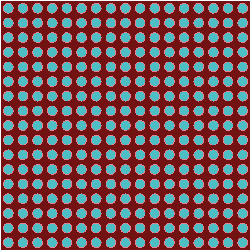

In [14]:
# Convert OpenMC's funky ppm to png
!convert materials-xy.ppm materials-xy.png

# Display the materials plot inline
Image(filename='materials-xy.png')

As we can see from the plot, we have a nice array of pin cells with fuel, cladding, and water! Before we run our simulation, we need to tell the code what we want to tally. The following code shows how to create a variety of tallies.

In [15]:
# Instantiate an empty TalliesFile
tallies_file = openmc.TalliesFile()
tallies_file._tallies = []

Instantiate a fission rate mesh Tally

In [16]:
# Instantiate a tally Mesh
mesh = openmc.Mesh(mesh_id=1)
mesh.type = 'regular'
mesh.dimension = [17, 17]
mesh.lower_left = [-10.71, -10.71]
mesh.width = [1.26, 1.26]

# Instantiate tally Filter
mesh_filter = openmc.Filter()
mesh_filter.mesh = mesh

# Instantiate energy Filter
energy_filter = openmc.Filter()
energy_filter.type = 'energy'
energy_filter.bins = np.array([0, 0.625e-6, 20.])

# Instantiate the Tally
tally = openmc.Tally(name='mesh tally')
tally.add_filter(mesh_filter)
tally.add_filter(energy_filter)
tally.add_score('fission')
tally.add_score('nu-fission')

# Add mesh and Tally to TalliesFile
tallies_file.add_mesh(mesh)
tallies_file.add_tally(tally)

Instantiate a cell Tally with nuclides

In [17]:
# Instantiate tally Filter
cell_filter = openmc.Filter(type='cell', bins=[fuel_cell.id])

# Instantiate the tally
tally = openmc.Tally(name='cell tally')
tally.add_filter(cell_filter)
tally.add_score('scatter-y2')
tally.add_nuclide(u235)
tally.add_nuclide(u238)

# Add mesh and tally to TalliesFile
tallies_file.add_tally(tally)

Create a "distribcell" Tally. The distribcell filter allows us to tally multiple repeated instances of the same cell throughout the geometry.

In [18]:
# Instantiate tally Filter
distribcell_filter = openmc.Filter(type='distribcell', bins=[moderator_cell.id])

# Instantiate tally Trigger for kicks
trigger = openmc.Trigger(trigger_type='std_dev', threshold=5e-5)
trigger.add_score('absorption')

# Instantiate the Tally
tally = openmc.Tally(name='distribcell tally')
tally.add_filter(distribcell_filter)
tally.add_score('absorption')
tally.add_score('scatter')
tally.add_trigger(trigger)

# Add mesh and tally to TalliesFile
tallies_file.add_tally(tally)

In [19]:
# Export to "tallies.xml"
tallies_file.export_to_xml()

Now we a have a complete set of inputs, so we can go ahead and run our simulation.

In [20]:
# Remove old HDF5 (summary, statepoint) files
!rm statepoint.*

# Run OpenMC with MPI!
executor.run_simulation()


       .d88888b.                             888b     d888  .d8888b.
      d88P" "Y88b                            8888b   d8888 d88P  Y88b
      888     888                            88888b.d88888 888    888
      888     888 88888b.   .d88b.  88888b.  888Y88888P888 888       
      888     888 888 "88b d8P  Y8b 888 "88b 888 Y888P 888 888       
      888     888 888  888 88888888 888  888 888  Y8P  888 888    888
      Y88b. .d88P 888 d88P Y8b.     888  888 888   "   888 Y88b  d88P
       "Y88888P"  88888P"   "Y8888  888  888 888       888  "Y8888P"
__________________888______________________________________________________
                  888
                  888

      Copyright:      2011-2015 Massachusetts Institute of Technology
      License:        http://mit-crpg.github.io/openmc/license.html
      Version:        0.7.0
      Git SHA1:       71dfde8d12942170a9a8d91796ab40a6e9becaaf
      Date/Time:      2015-10-03 09:52:00
      OpenMP Threads: 4

 =======================

0

## Tally Data Processing

In [21]:
# We do not know how many batches were needed to satisfy the 
# tally trigger(s), so find the statepoint file(s)
statepoints = glob.glob('statepoint.*.h5')

# Load the last statepoint file
sp = StatePoint(statepoints[-1])

In [22]:
# Load the summary file and link with statepoint
su = Summary('summary.h5')
sp.link_with_summary(su)

**Analyze the mesh fission rate tally**

In [23]:
# Find the mesh tally with the StatePoint API
tally = sp.get_tally(name='mesh tally')

# Print a little info about the mesh tally to the screen
print(tally)

Tally
	ID             =	10000
	Name           =	mesh tally
	Filters        =	
                		mesh	[1]
                		energy	[  0.00000000e+00   6.25000000e-07   2.00000000e+01]
	Nuclides       =	total 
	Scores         =	[u'fission', u'nu-fission']
	Estimator      =	tracklength



Use the new Tally data retrieval API with pure NumPy

In [24]:
# Get the relative error for the thermal fission reaction 
# rates in the four corner pins 
data = tally.get_values(scores=['fission'], filters=['mesh', 'energy'], \
                        filter_bins=[((1,1),(1,17), (17,1), (17,17)), \
                                    ((0., 0.625e-6),)], value='rel_err')
print(data)

[[[ 0.15044911]]

 [[ 0.09149973]]

 [[ 0.27611475]]

 [[ 0.12476673]]]


In [25]:
# Get a pandas dataframe for the mesh tally data
df = tally.get_pandas_dataframe(nuclides=False)

# Print the first twenty rows in the dataframe
df.head(20)

mesh 1             energy [MeV]       score      mean std. dev.
         x  y  z                                                   
bin                                                                
0        1  1  1  0.0e+00 - 6.3e-07     fission  0.000236  0.000035
1        1  1  1  0.0e+00 - 6.3e-07  nu-fission  0.000574  0.000086
2        1  1  1  6.3e-07 - 2.0e+01     fission  0.000072  0.000006
3        1  1  1  6.3e-07 - 2.0e+01  nu-fission  0.000190  0.000014
4        1  2  1  0.0e+00 - 6.3e-07     fission  0.000451  0.000058
5        1  2  1  0.0e+00 - 6.3e-07  nu-fission  0.001100  0.000141
6        1  2  1  6.3e-07 - 2.0e+01     fission  0.000095  0.000006
7        1  2  1  6.3e-07 - 2.0e+01  nu-fission  0.000250  0.000016
8        1  3  1  0.0e+00 - 6.3e-07     fission  0.000575  0.000080
9        1  3  1  0.0e+00 - 6.3e-07  nu-fission  0.001401  0.000194
10       1  3  1  6.3e-07 - 2.0e+01     fission  0.000134  0.000011
11       1  3  1  6.3e-07 - 2.0e+01  nu-fission  0.000353  0.000028
12       1  4  1  0.0e+00 - 6.3e-07     fission  0.000655  0.000071
13       1  4  1  0.0e+00 - 6.3e-07  nu-fission  0.001596  0.000174
14       1  4  1  6.3e-07 - 2.0e+01     fission  0.000149  0.000009
15       1  4  1  6.3e-07 - 2.0e+01  nu-fission  0.000391  0.000023
16       1  5  1  0.0e+00 - 6.3e-07     fission  0.000781  0.000078
17       1  5  1  0.0e+00 - 6.3e-07  nu-fission  0.001903  0.000191
18       1  5  1  6.3e-07 - 2.0e+01     fission  0.000185  0.000009
19       1  5  1  6.3e-07 - 2.0e+01  nu-fission  0.000484  0.000024

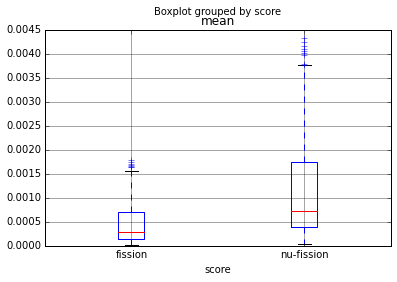

In [26]:
# Create a boxplot to view the distribution of
# fission and nu-fission rates in the pins
bp = df.boxplot(column='mean', by='score')

<matplotlib.colorbar.Colorbar instance at 0x7fcc91dd2518>

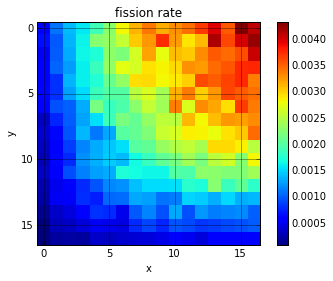

In [27]:
# Extract thermal nu-fission rates from pandas
fiss = df[df['score'] == 'nu-fission']
fiss = fiss[fiss['energy [MeV]'] == '0.0e+00 - 6.3e-07']

# Extract mean and reshape as 2D NumPy arrays
mean = fiss['mean'].reshape((17,17))

pylab.imshow(mean, interpolation='nearest')
pylab.title('fission rate')
pylab.xlabel('x')
pylab.ylabel('y')
pylab.colorbar()

**Analyze the cell+nuclides scatter-y2 rate tally**

In [28]:
# Find the cell Tally with the StatePoint API
tally = sp.get_tally(name='cell tally')

# Print a little info about the cell tally to the screen
print(tally)

Tally
	ID             =	10001
	Name           =	cell tally
	Filters        =	
                		cell	[10000]
	Nuclides       =	U-235 U-238 
	Scores         =	[u'scatter-Y0,0', u'scatter-Y1,-1', u'scatter-Y1,0', u'scatter-Y1,1', u'scatter-Y2,-2', u'scatter-Y2,-1', u'scatter-Y2,0', u'scatter-Y2,1', u'scatter-Y2,2']
	Estimator      =	analog



In [29]:
# Get a pandas dataframe for the cell tally data
df = tally.get_pandas_dataframe()

# Print the first twenty rows in the dataframe
df.head(100)

,cell,nuclide,score,mean,std. dev.
bin,,,,,
0,10000,U-235,"scatter-Y0,0",0.036453,0.001219
1,10000,U-235,"scatter-Y1,-1",0.000302,0.000314
2,10000,U-235,"scatter-Y1,0",-0.000006,0.000347
3,10000,U-235,"scatter-Y1,1",0.000244,0.000286
4,10000,U-235,"scatter-Y2,-2",0.000184,0.000211
5,10000,U-235,"scatter-Y2,-1",0.000067,0.000173
6,10000,U-235,"scatter-Y2,0",0.000353,0.000210
7,10000,U-235,"scatter-Y2,1",-0.000266,0.000263
8,10000,U-235,"scatter-Y2,2",-0.000246,0.000153


Use the new Tally data retrieval API with pure NumPy

In [30]:
# Get the standard deviations for two of the spherical harmonic
# scattering reaction rates 
data = tally.get_values(scores=['scatter-Y2,2', 'scatter-Y0,0'], 
                        nuclides=['U-238', 'U-235'], value='std_dev')
print(data)

[[[ 0.00122163  0.00824348]
  [ 0.00015287  0.00121882]]]


**Analyze the distribcell tally**

In [31]:
# Find the distribcell Tally with the StatePoint API
tally = sp.get_tally(name='distribcell tally')

# Print a little info about the distribcell tally to the screen
print(tally)

Tally
	ID             =	10002
	Name           =	distribcell tally
	Filters        =	
                		distribcell	[10002]
	Nuclides       =	total 
	Scores         =	[u'absorption', u'scatter']
	Estimator      =	tracklength



Use the new Tally data retrieval API with pure NumPy

In [32]:
# Get the relative error for the scattering reaction rates in
# the first 30 distribcell instances 
data = tally.get_values(scores=['scatter'], filters=['distribcell'],
                        filter_bins=[range(10)], value='rel_err')
print(data)

[[[ 0.0400168 ]]

 [[ 0.05233031]]

 [[ 0.03819276]]

 [[ 0.02900783]]

 [[ 0.03176394]]

 [[ 0.03046477]]

 [[ 0.03864163]]

 [[ 0.02455132]]

 [[ 0.02282716]]

 [[ 0.02162945]]]


Print the distribcell tally dataframe **without** OpenCG info

In [33]:
# Get a pandas dataframe for the distribcell tally data
df = tally.get_pandas_dataframe(nuclides=False)

# Print the last twenty rows in the dataframe
df.tail(20)

,distribcell,score,mean,std. dev.
bin,,,,
558,279,absorption,0.000085,0.000008
559,279,scatter,0.013429,0.000449
560,280,absorption,0.000095,0.000014
561,280,scatter,0.014770,0.000783
562,281,absorption,0.000107,0.000013
563,281,scatter,0.015044,0.000605
564,282,absorption,0.000110,0.000010
565,282,scatter,0.016090,0.000795
566,283,absorption,0.000121,0.000012


Print the distribcell tally dataframe **with** OpenCG info

In [34]:
# Get a pandas dataframe for the distribcell tally data
df = tally.get_pandas_dataframe(summary=su, nuclides=False)

# Print the last twenty rows in the dataframe
df.head(20)

level 1      level 2          level 3        distribcell       score  \
       cell univ     lat             cell   univ                           
         id   id      id  x  y  z      id     id                           
bin                                                                        
0     10003    0   10001  0  0  0   10002  10000           0  absorption   
1     10003    0   10001  0  0  0   10002  10000           0     scatter   
2     10003    0   10001  1  0  0   10002  10000           1  absorption   
3     10003    0   10001  1  0  0   10002  10000           1     scatter   
4     10003    0   10001  2  0  0   10002  10000           2  absorption   
5     10003    0   10001  2  0  0   10002  10000           2     scatter   
6     10003    0   10001  3  0  0   10002  10000           3  absorption   
7     10003    0   10001  3  0  0   10002  10000           3     scatter   
8     10003    0   10001  4  0  0   10002  10000           4  absorption   
9     10003    0   10001  4  0  0   10002  10000           4     scatter   
10    10003    0   10001  5  0  0   10002  10000           5  absorption   
11    10003    0   10001  5  0  0   10002  10000           5     scatter   
12    10003    0   10001  6  0  0   10002  10000           6  absorption   
13    10003    0   10001  6  0  0   10002  10000           6     scatter   
14    10003    0   10001  7  0  0   10002  10000           7  absorption   
15    10003    0   10001  7  0  0   10002  10000           7     scatter   
16    10003    0   10001  8  0  0   10002  10000           8  absorption   
17    10003    0   10001  8  0  0   10002  10000           8     scatter   
18    10003    0   10001  9  0  0   10002  10000           9  absorption   
19    10003    0   10001  9  0  0   10002  10000           9     scatter   

         mean std. dev.  
                         
                         
bin                      
0    0.000136  0.000017  
1    0.018504  0.000740  
2    0.000231  0.000031  
3    0.029149  0.001525  
4    0.000306  0.000032  
5    0.039770  0.001519  
6    0.000339  0.000028  
7    0.046708  0.001355  
8    0.000433  0.000031  
9    0.056359  0.001790  
10   0.000538  0.000028  
11   0.064943  0.001978  
12   0.000588  0.000028  
13   0.070231  0.002714  
14   0.000670  0.000041  
15   0.075852  0.001862  
16   0.000745  0.000039  
17   0.086234  0.001968  
18   0.000731  0.000039  
19   0.090448  0.001956

In [35]:
# Show summary statistics for absorption distribcell tally data
absorption = df[df['score'] == 'absorption']
absorption[['mean', 'std. dev.']].dropna().describe()

# Note that the maximum standard deviation does indeed
# meet the 5e-4 threshold set by the tally trigger

,mean,std. dev.
,,
,,
count,289.000000,289.000000
mean,0.000416,0.000025
std,0.000238,0.000011
min,0.000023,0.000004
25%,0.000206,0.000017
50%,0.000391,0.000024
75%,0.000626,0.000031
max,0.000928,0.000061


Perform a statistical test comparing the tally sample distributions for two categories of fuel pins.

In [36]:
# Extract tally data from pins in the pins divided along y=x diagonal 
multi_index = ('level 2', 'lat',)
lower = df[df[multi_index + ('x',)] + df[multi_index + ('y',)] < 16]
upper = df[df[multi_index + ('x',)] + df[multi_index + ('y',)] > 16]
lower = lower[lower['score'] == 'absorption']
upper = upper[upper['score'] == 'absorption']

# Perform non-parametric Mann-Whitney U Test to see if the 
# absorption rates (may) come from same sampling distribution
u, p = scipy.stats.mannwhitneyu(lower['mean'], upper['mean'])
print('Mann-Whitney Test p-value: {0}'.format(p))

Mann-Whitney Test p-value: 0.474494586047


Note that the symmetry implied by the y=x diagonal ensures that the two sampling distributions are identical. Indeed, as illustrated by the test above, for any reasonable significance level (*e.g.*, $\alpha$=0.05) one would **not reject** the null hypothesis that the two sampling distributions are identical.

Next, perform the same test but with two groupings of pins which are not symmetrically identical to one another.

In [37]:
# Extract tally data from pins in the pins divided along y=-x diagonal
multi_index = ('level 2', 'lat',)
lower = df[df[multi_index + ('x',)] > df[multi_index + ('y',)]]
upper = df[df[multi_index + ('x',)] < df[multi_index + ('y',)]]
lower = lower[lower['score'] == 'absorption']
upper = upper[upper['score'] == 'absorption']

# Perform non-parametric Mann-Whitney U Test to see if the 
# absorption rates (may) come from same sampling distribution
u, p = scipy.stats.mannwhitneyu(lower['mean'], upper['mean'])
print('Mann-Whitney Test p-value: {0}'.format(p))

Mann-Whitney Test p-value: 1.364780046e-41


Note that the asymmetry implied by the y=-x diagonal ensures that the two sampling distributions are *not* identical. Indeed, as illustrated by the test above, for any reasonable significance level (*e.g.*, $\alpha$=0.05) one would **reject** the null hypothesis that the two sampling distributions are identical.

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


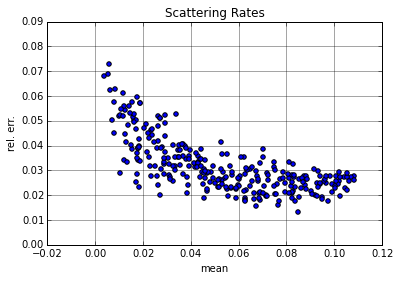

In [38]:
# Extract the scatter tally data from pandas
scatter = df[df['score'] == 'scatter']

scatter['rel. err.'] = scatter['std. dev.'] / scatter['mean']

# Show a scatter plot of the mean vs. the std. dev.
scatter.plot(kind='scatter', x='mean', y='rel. err.', title='Scattering Rates')

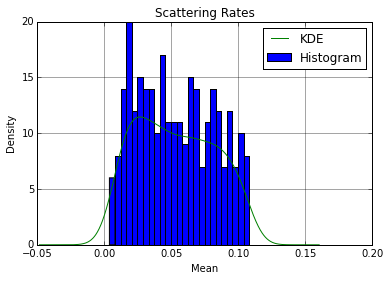

In [39]:
# Plot a histogram and kernel density estimate for the scattering rates
scatter['mean'].plot(kind='hist', bins=25)
scatter['mean'].plot(kind='kde')
pylab.title('Scattering Rates')
pylab.xlabel('Mean')
pylab.legend(['KDE', 'Histogram'])